In [41]:
import torch
from torch import distributions as dist

import itertools
import pickle
import operator
import importlib

import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 15})
plt.rcParams.update({'xtick.labelsize': 15})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models

import helpers, opt, bases

In [44]:
with open('../inputs/gb1.pkl', 'rb') as f:
    t = pickle.load(f)

X = t[0] # one-hot encoding of X
T = t[1] # tokenized encoding of X
A = t[2]
y = t[3].values

seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i

In [45]:
wt = "VDGV"  # wt as string
aas = 'ARNDCQEGHILKMFPSTWYV'

In [46]:
ground = [(aa, i) for aa in 'ARNDCQEGHILKMFPSTWYV' for i in range(4)]

In [ ]:
%%time
helpers = importlib.reload(helpers)
opt = importlib.reload(opt)
bases = importlib.reload(bases)

singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
train_seqs = singles
wt_inds = [seq_to_x[wt]]
train_inds = wt_inds + [seq_to_x[seq] for seq in train_seqs]
np.random.seed(1245120)
train_inds = wt_inds + list(np.random.choice(len(X), 100, replace=True))

X_train = X[train_inds]
y_train = y[train_inds]
X_test = X
y_true = y

A_train = A[train_inds]
A_test = A


n_start = 35
max_its = 30
rounds = 4
L = 4
n = 100

observed_inds = [train_inds]
X_sampled = [A[train_inds]]
y_sampled = [y[train_inds]]



libraries = []
histories = []

for rou in range(rounds):
    print('Round %d' %rou)
    inds = sorted(set(itertools.chain(*observed_inds)))
    print(len(inds))
    dic, _, mo = helpers.get_predictions(A[inds], y[inds], A_test, 
                                         one_hots=X_test, its=2000, 
                                         lr=1e-2, return_model=True)
    seen_seqs = [helpers.decode_X(X[i]) for i in inds]
    for s in seen_seqs:
        dic[s] = 0.0
    print()
    seed = helpers.get_seed(dic)
    chosen, obj = bases.greedy(bases.sample_obj, seed, 
                               obj_args=(mo, tau, seq_to_x, A), 
                               obj_kwargs={'its': 1000,
                                           'observed': seen_seqs})
    libraries.append(chosen)
    histories.append(obj)
    seqs = helpers.seqs_from_set(chosen, L)
    inds = np.random.choice(len(seqs), n, replace=True)
    sampled_seqs = [seqs[i] for i in inds]
    inds = [seq_to_x[s] for s in sampled_seqs]
    X_sampled.append(A[inds])
    y_sampled.append(y[inds])
    observed_inds.append(inds)
    
    

Round 0
101
Iteration 2000 of 2000	NLML: 48.2267	sn: 0.209592	


In [73]:
df = pd.DataFrame(np.power(10, np.concatenate(y_sampled)), columns=['y'])
df['round'] = [0] * (1 + n) + [1] * n + [2] * n + [3] * n + [4] * n
df.head()


,y,round
0,0.002108,0
1,0.003384,0
2,0.003150,0
3,0.068828,0
4,0.000100,0


In [74]:
histories

[tensor(-0.1310), tensor(-0.1180), tensor(-0.1110), tensor(-3.6150)]

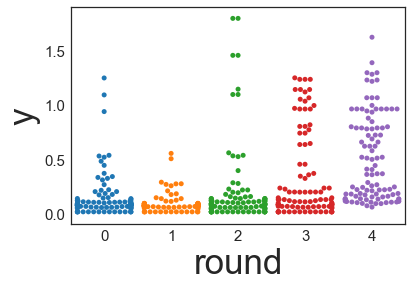

In [75]:
df = pd.DataFrame(np.exp(np.concatenate(y_sampled)), columns=['y'])
df['round'] = [0] * (n + 1) + [1] * n + [2] * n + [3] * n + [4] * n
_ = sns.swarmplot(data=df, x='round', y='y')

In [76]:
[max(yy) for yy in y_sampled]

[0.22641667584020303,
 -0.5837682615899172,
 0.5901126924510388,
 0.22722075233172428,
 0.48871506975799484]

In [77]:
[opt.get_N(lib, L) for lib in libraries]

[300, 240, 90, 120]